In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(3931, 2048)

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [9]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, ga

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.8min


[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 1.6min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total= 1.6min
[CV] .............. C=0.01, gamma=1e-08, score=0.505718, total= 1.6min
[CV] C=0.01, gamma=0.001 .............................................
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 1.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 1.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total= 1.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.505718, total= 1.6min
[CV] C

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.1min


[CV] ............. C=0.01, gamma=0.0001, score=0.759848, total= 1.7min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.755725, total= 1.7min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 1.9min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total= 1.9min
[CV] .............. C=0.01, gamma=1e-07, score=0.505718, total= 1.9min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.4min


[CV] .............. C=0.01, gamma=0.001, score=0.866582, total= 1.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.844784, total= 1.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.860051, total= 1.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.875318, total= 1.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.872774, total= 1.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.765903, total= 1.3min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.844981, total= 1.5min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.5min


[CV] ................ C=0.01, gamma=0.1, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505718, total= 1.9min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505089, total= 1.9min
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total= 1.9min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  7.2min


[CV] ............... C=0.1, gamma=1e-08, score=0.505718, total= 1.5min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505089, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 1.5min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505718, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total= 1.4min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  8.7min


[CV] .............. C=0.1, gamma=0.0001, score=0.884224, total=  46.5s
[CV] C=0.1, gamma=0.1 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.856234, total= 1.1min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .............. C=0.1, gamma=0.0001, score=0.880559, total= 1.1min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.922392, total=  32.2s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.931298, total=  33.3s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ................ C=0.1, gamma=0.01, score=0.866582, total=  56.0s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ................ C=0.1, gamma=0.01, score=0.891858, total=  56.5s
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  9.8min


[CV] ............... C=0.1, gamma=1e-06, score=0.505718, total= 1.9min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 1.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 1.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 1.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.505089, total= 1.9min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.520966, total= 1.4min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.519084, total= 1.4min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 12.3min


[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total= 1.3min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-05, score=0.880559, total=  46.2s
[CV] C=1.0, gamma=0.0001 .............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.932656, total=  27.4s
[CV] C=1.0, gamma=0.0001 .............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.926209, total=  27.7s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505718, total= 1.9min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total= 1.9min
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 13.4min


[CV] ............... C=1.0, gamma=1e-06, score=0.751908, total= 1.2min
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=1e-07, score=0.505089, total= 1.9min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-07, score=0.505089, total= 1.9min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-05, score=0.876590, total=  46.4s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-05, score=0.882952, total=  46.9s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.767176, total= 1.2min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.961881, total=  22.1s
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 15.1min


[CV] ................ C=1.0, gamma=0.01, score=0.916031, total= 1.0min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=0.01, score=0.955471, total= 1.1min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.750636, total= 1.5min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.745547, total= 1.5min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.721374, total= 1.5min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.759542, total= 1.5min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.604326, total= 1.4min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 17.3min


[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total= 1.4min
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.505718, total= 1.9min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.553435, total= 1.9min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.544529, total= 1.9min
[CV] C=10.0, gamma=0.001 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.547074, total= 1.9min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.505089, total= 1.9min
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.881830, total=  45.5s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 17.9min


[CV] .............. C=10.0, gamma=1e-07, score=0.755725, total= 1.6min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.969466, total=  24.7s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.965649, total=  24.7s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.751908, total= 1.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.777354, total= 1.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.980916, total=  26.3s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.767176, total= 1.3min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 20.4min


[CV] ............... C=10.0, gamma=10.0, score=0.541985, total= 1.4min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.881830, total=  45.2s
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.930114, total=  26.6s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-06, score=0.924936, total=  27.1s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-05, score=0.958015, total=  19.4s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-05, score=0.952986, total=  20.4s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-05, score=0.946565, total=  19.3s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 21.4min


[CV] ............. C=100.0, gamma=1e-07, score=0.860051, total= 1.0min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............... C=10.0, gamma=10.0, score=0.549618, total= 1.9min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.963104, total=  16.6s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............... C=10.0, gamma=10.0, score=0.548346, total= 1.9min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.968193, total=  16.4s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............ C=100.0, gamma=0.0001, score=0.983461, total=  17.9s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.889313, total= 1.0min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 23.8min


[CV] ............... C=100.0, gamma=0.1, score=0.734435, total= 1.5min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.765903, total= 1.4min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.765903, total= 1.4min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.736641, total= 1.4min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.750636, total= 1.4min
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.924936, total=  27.4s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.542567, total= 1.4min
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed: 26.4min remaining:  1.5min


[CV] .............. C=1000.0, gamma=0.1, score=0.765903, total= 1.3min
[CV] .............. C=1000.0, gamma=0.1, score=0.750636, total= 1.3min
[CV] .............. C=1000.0, gamma=0.1, score=0.736641, total= 1.3min
[CV] ............. C=1000.0, gamma=0.01, score=0.938931, total= 1.6min
[CV] .............. C=1000.0, gamma=1.0, score=0.589581, total= 1.3min
[CV] .............. C=1000.0, gamma=1.0, score=0.600509, total= 1.2min
[CV] ............. C=1000.0, gamma=10.0, score=0.548346, total= 1.2min
[CV] ............. C=1000.0, gamma=10.0, score=0.549618, total= 1.2min
[CV] .............. C=1000.0, gamma=0.1, score=0.765903, total= 1.7min
[CV] .............. C=1000.0, gamma=0.1, score=0.734435, total= 1.7min
[CV] .............. C=1000.0, gamma=1.0, score=0.609415, total= 1.6min
[CV] .............. C=1000.0, gamma=1.0, score=0.610687, total= 1.6min
[CV] ............. C=1000.0, gamma=10.0, score=0.542567, total= 1.6min
[CV] ............. C=1000.0, gamma=10.0, score=0.541985, total= 1.6min
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 27.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [10]:
top_model.cv_results_

{'mean_fit_time': array([ 82.33421121,  84.31079197,  87.10826426,  85.96814499,
         76.67141223,  48.9129766 ,  70.53831739,  86.51474185,
         90.89737558,  81.6407043 ,  69.141645  ,  68.99764838,
         89.63377395,  78.4913209 ,  42.0871778 ,  24.89633985,
         45.32722077,  66.80472717,  75.7337822 ,  85.45807548,
         74.68410664,  85.02669325,  56.89649386,  41.95501904,
         23.14526782,  20.95793757,  47.25110378,  76.04566746,
         78.12528334,  81.55065756,  80.1242166 ,  68.95665421,
         37.23103476,  24.56550021,  18.57447362,  18.82117138,
         70.36873417,  79.3806396 ,  72.57622237,  80.63075705,
         69.45051842,  44.08873177,  22.56359982,  16.18445315,
         14.15356665,  19.97597561,  64.98288898,  68.60275898,
         86.15109563,  76.48287654,  48.29161415,  27.41628118,
         19.13541842,  14.29446359,  14.8103837 ,  16.89040036,
         61.51940761,  71.50270882,  72.04986434,  70.10620141]),
 'mean_score_time': a

In [11]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.76164, std: 0.00879, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.86390, std: 0.01092, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.86212, std: 0.01429, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [12]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.001} - score: 0.9728


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


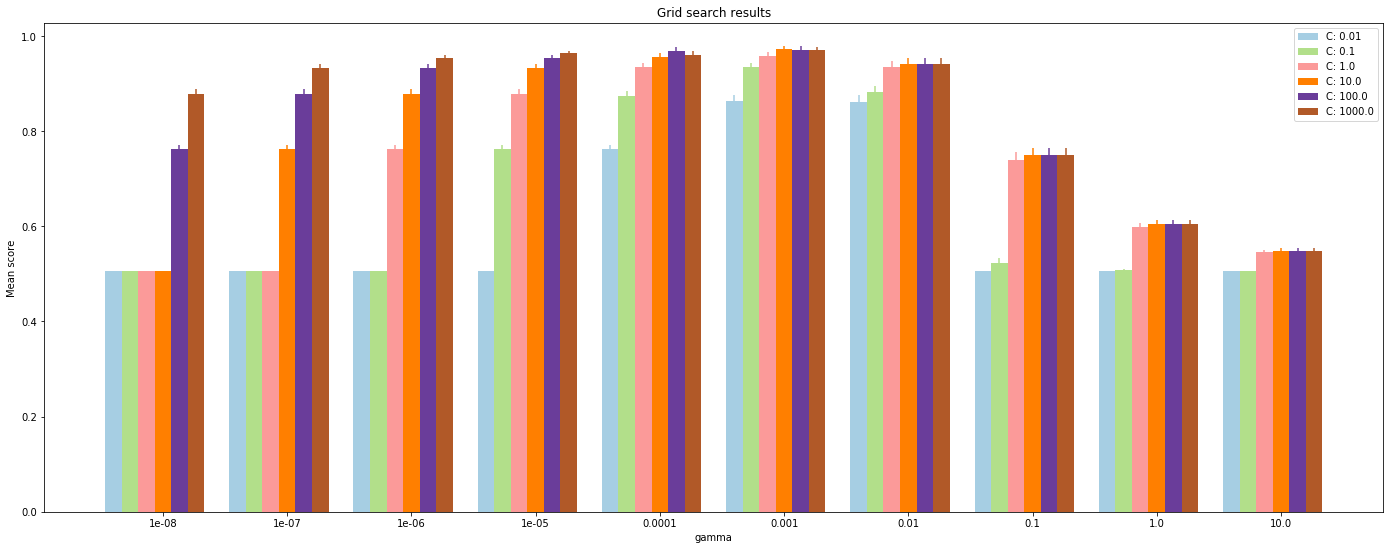

In [13]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()